## Chapter 17
---
# Support Vector Machines
Formally, a hyperplane is an n-1 subspace in an n-dimensional space.

Support vector machine classify data by finding the hyperplane that maximizes the margin between the classes in the training data. 

## 17.1 Training a Linear Classifier

In [1]:
from sklearn.svm import LinearSVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = datasets.load_iris()
features = iris.data[:100, :2]
target = iris.target[:100]

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = LinearSVC(C=1.0)

model = svc.fit(features_standardized, target)

### Discussion
scikit-learn's `LinearSVC` implements a simple SVC. To get an intuition behind what an SVC is doing, let us plot out the data and hyperplane. While SVCs work welll in high dimensions, in our solution we only loaded two features and took a subset of observations so that the data contains only two classes. This will let us visualize the model. Recall that SVC attempts to find the hyperplane--a line when we only have two dimensions--with the maximum margin between the classes. In the following code, we plot the two classes on a two-dimensional space, then draw the hyperplane.

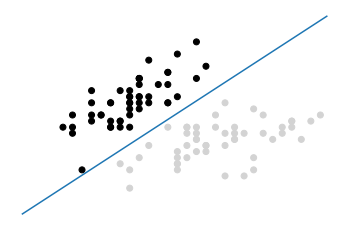

((-2.75, 2.75, -3.5354245818919763, 3.9541499380158545), None)

In [2]:
import matplotlib.pyplot as plt

color = ["black" if c == 0 else "lightgrey" for c in target]
plt.scatter(features_standardized[:,0], features_standardized[:,1], c=color)

w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2.5, 2.5)
yy = a * xx - (svc.intercept_[0]) / w[1]

plt.plot(xx, yy)
plt.axis("off"), plt.show()

## 17.2 Handling Linearly Inseparable Classes Using Kernels

In [8]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

np.random.seed(0)

features = np.random.randn(200, 2)

target_xor = np.logical_xor(features[:, 0] > 0, features[:, 1] > 0)
target = np.where(target_xor, 0, 1)

svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

model = svc.fit(features, target)

### Discussion
For reasons best learned elsewhere, a support vector classifier can be represented as:
$$
f(x) = \beta_0 + \sum_{i\in s}^{p}{\alpha_i K(x_i, x_{i'})}
$$
where \beta is the bias, S is the set of all support vector observations, \alpha are the model parameters to be learned, and $(x_i, x_{i'})$ are pairs of two support vector observations, $x_i$ and $x_{i;}$. Don't worry if you don't understand kernel functions. For our purposed, just realized that K

1. Determines the type of hyperplane used to separate our classes and
2. we create different hyperplanes by using different kernels.

For example if we wanted the basic linear hyperplane used to separate our classes like the one we used in Recipe 17.1, we can use the linear kernel:

$$
K(x_i, x_{i'}) = \sum_{j=1}^{p}{x_{ij}x_{i'j}}
$$
where p is the number of features. However, if we wanted a nonlinear decision boundary, we swap the lienar kernel with a polynomial kernel:
$$
K(x_i, x_{i'}) = (1 + \sum_{j=1}^{p}{x_{ij}x_{i'j}})^2
$$
where d is the degree of the polynomial kernel function. Alternatively, we can use oen of the most common kernels in support vector machines, teh radial basis funciton kernel:

$$
K(x_i, x_{i'}) = e^{(-\gamma \sum_{j=1}^{p}{(x_{ij}x_{i'j})^2})}
$$
where \gamma is a hyperparameter and must be greater than zero. The main point of the preceding explanation is that if we have lienarly inseparable data we can swap out a lienar kernel with an alternative kernel to create a nonlinear hyperplane decision boundary.

We can understand the intuition behidn kernels by visualizing a simple example. This function, based on one by Sebastian Raschka, plots the observations and decision boundary hyperlane of a two-dimensional space. You do not need to understand how this function works; I have included it here so you can experiment on your own:

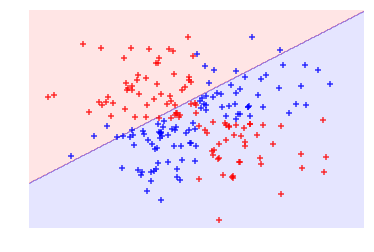

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier):
    cmap = ListedColormap(("red", "blue"))
    xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker="+", label=cl)
        
svc_linear = SVC(kernel="linear", random_state=0, C=1)

svc_linear.fit(features, target)
plot_decision_regions(features, target, classifier=svc_linear)
plt.axis("off"), plt.show()

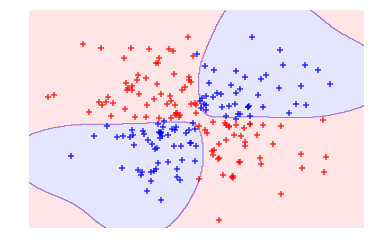

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [17]:
svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

## 17.3 Creating Predicted Probabilities

In [20]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = datasets.load_iris()
features = iris.data
target = iris.target

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = SVC(kernel="linear", probability=True, random_state=0)

model = svc.fit(features_standardized, target)

new_observation = [[.4, .4, .4, .4]]
model.predict_proba(new_observation)

array([[0.00588822, 0.96874828, 0.0253635 ]])

### Discussion
Many of the supervised learning algorithms we have covered used probability estimates to predict classes. For example, in k-nearest neighbor, an observation's k neighbor's classes were treated as votes to create a probability that an observation was of that class. THen the class with the highest probability was predicted.

SVC's used of a hyperplane to create decision regions does not naturally output a probability estimate that an observation is a member of acertain class. However, we can in fact output calibrated class probabilities with a few aveats. In an SVC with two classes, Platt scaling can be used, wherein first the SVC is trained, and then a separate cross-validated logistic regression is trained to map the SVC outputs into probabilities:
$$
P(y=1 | x) = \frac{1}{1+e^{(A * f(X) + B)}}
$$
where A and B are parameter vectors and f is the ith observation's signed distanced from the hyperplane. When we have more than two classes, an extension of Platt scaling is used.


## 17.4 Identifying Support Vectors

In [21]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = datasets.load_iris()
features = iris.data[:100,:]
target = iris.target[:100]

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = SVC(kernel="linear", random_state=0)

model = svc.fit(features_standardized, target)
model.support_vectors_

array([[-0.5810659 ,  0.43490123, -0.80621461, -0.50581312],
       [-1.52079513, -1.67626978, -1.08374115, -0.8607697 ],
       [-0.89430898, -1.46515268,  0.30389157,  0.38157832],
       [-0.5810659 , -1.25403558,  0.09574666,  0.55905661]])

## 17.5 Handling Imbalanced Classes

In [23]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = datasets.load_iris()
features = iris.data[:100,:]
target = iris.target[:100]

features = features[40:, :]
target = target[40:]

target = np.where((target == 0), 0, 1)

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0)

model = svc.fit(features_standardized, target)